In [1]:
import os
import pandas as pd
import numpy as np
from numpy import array
from matplotlib import pyplot as plt
#读取arousal数据
arousal = pd.read_csv('arousal.csv',index_col=0)
data_arousal=[]
for i in range(0,744):
    X=np.array(arousal.iloc[i].dropna(axis=0,how='any'))
    data_arousal.append(X)

#读取valence数据
valence = pd.read_csv('valence.csv',index_col=0)
data_valence=[]
for i in range(0,744):
    X=np.array(valence.iloc[i].dropna(axis=0,how='any'))
    data_valence.append(X)
'''
Blues:0-99(100)   Classical:100-215(116)  Country:216-320(105)  Electronic:321-412(92)
Folk:413-483(71)  Jazz:484-588(105)  Pop:589-666(78)  Rock:667-743(77)
'''
blues_arousal,blues_valence=data_arousal[0:100],data_valence[0:100]
classical_arousal,classical_valence=data_arousal[100:216],data_valence[100:216]
country_arousal,country_valence=data_arousal[216:321],data_valence[216:321]
electronic_arousal,electronic_valence=data_arousal[321:413],data_valence[321:413]
folk_arousal,folk_valence=data_arousal[413:484],data_valence[413:484]
jazz_arousal,jazz_valence=data_arousal[484:589],data_valence[484:589]
pop_arousal,pop_valence=data_arousal[589:667],data_valence[589:667]
rock_arousal,rock_valence=data_arousal[667:744],data_valence[667:744]

In [2]:
'''
再循环八类的变量名，把每类的 coefficient，R2,if_trend都写入csv文件中
'''
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
trend_model = LinearRegression(normalize=True,fit_intercept=True)
time=np.arange(60)
names=['blues','classical','country','electronic','folk','jazz','pop','rock']
for name in names:
    coefficient_list=[]
    R2_list=[]
    trend_list=[]
    data=name+'_valence'
    the_data=locals()[data]
    index=np.arange(len(the_data))
    for i in range(0,len(the_data)):  
        trend_model.fit(np.array(time).reshape(-1, 1),np.array(the_data[i]).reshape(-1, 1))
        data_pred = trend_model.predict(np.array(time).reshape(-1, 1))
        r2 = r2_score(the_data[i],data_pred)
        R2_list.append(r2)
        coefficient_list.append(trend_model.coef_[0])
    exec("coef_%s=%s"%(name,coefficient_list))   
    exec("R2_%s=%s"%(name,R2_list))#%s代表所有类型的占位符

In [3]:
#计算标准差均值等
for name in names:
    data='coef_'+name
    the_data=locals()[data]
    #the_data=abs(np.array(the_data))
    a=np.std(the_data)
    a=np.round(a,5)
    print(a)

0.00175
0.00174
0.00143
0.00198
0.00188
0.0018
0.00175
0.0019


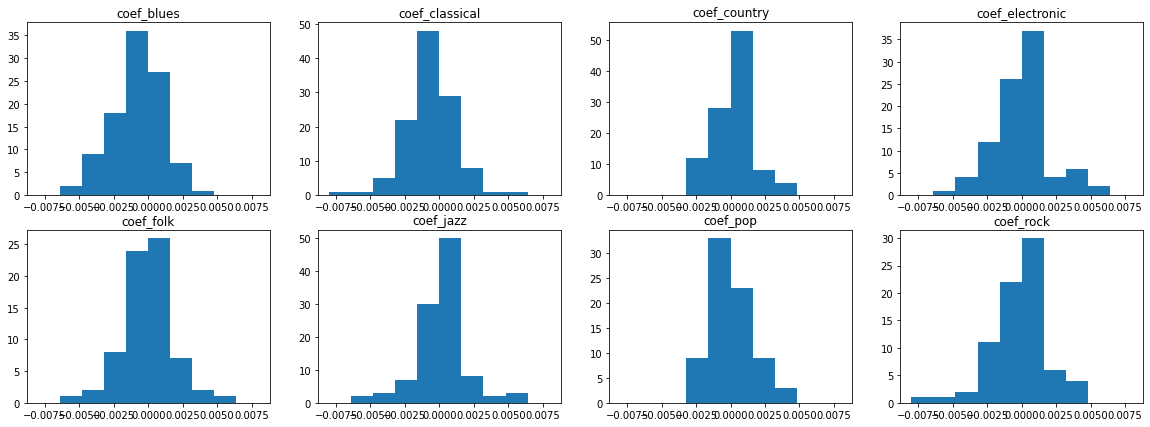

In [4]:
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(20,7))
i=0
j=0
names=['blues','classical','country','electronic','folk','jazz','pop','rock']
for name in names:
    data='coef_'+name
    the_data=locals()[data]
    the_data=np.round(the_data,4)
    #the_data=abs(the_data)
    ax[i][j].set_title(data)
    ax[i][j].hist(the_data,range=(-0.008,0.008))
    j=j+1
    if j==4:
        i=1
        j=0

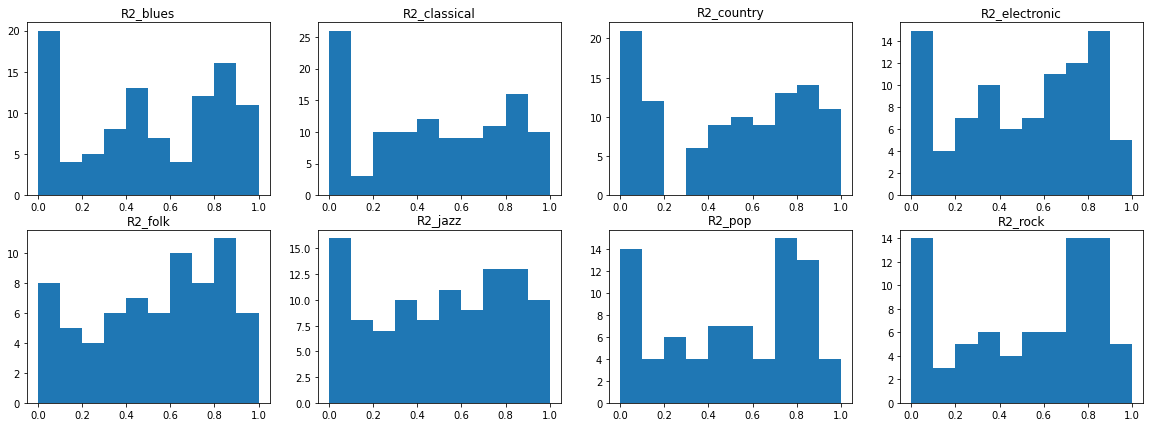

In [5]:
#激活度中，每类R2的频率分布直方图
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(20,7))
i=0
j=0
names=['blues','classical','country','electronic','folk','jazz','pop','rock']
for name in names:
    data='R2_'+name
    the_data=locals()[data]
    the_data=np.round(the_data,4)
    #the_data=abs(the_data)
    ax[i][j].set_title(data)
    ax[i][j].hist(the_data,range=(0,1))
    j=j+1
    if j==4:
        i=1
        j=0
#由下图可知，classical和folk两类的线性拟合度较好，jazz和rock两类的拟合程度较差，说明这两类激活度的波动较大。

In [6]:
'''
周期性分析—自相关
'''
#先减去趋势项
from numpy import array
names=['blues','classical','country','electronic','folk','jazz','pop','rock']
time=np.arange(60)
for name in names:
    data=name+'_arousal'
    the_data=locals()[data]
    off_trend=[]
    for i in range(0,len(the_data)): 
        trend_model.fit(np.array(time).reshape(-1, 1),np.array(the_data[i]).reshape(-1, 1))
        data_pred = trend_model.predict(np.array(time).reshape(-1, 1))
        data_pred = np.squeeze(data_pred)#缩减维度
        off_trend.append(the_data[i]-data_pred)
    exec("offtrend_%s=%s"%(name,off_trend))#保存变量off_trend_类名

In [7]:
from statsmodels.tsa.stattools import acf,pacf
names=['blues','classical','country','electronic','folk','jazz','pop','rock']
for name in names:
    data='offtrend_'+name
    the_data=locals()[data]
    max_list=[]#偏自相关最大值
    index_list=[]#最大值的索引
    rate_rel_list=[]#相对周期显著性
    rate_abs_list=[]#绝对周期显著性
    peroid_list=[]#是否有周期性
    index=np.arange(len(the_data))
    for i in range(0,len(the_data)): 
        Pacf=pacf(the_data[i],nlags=29)[4:]#认为情感感知的变化至少为2s以上，所以从lag=4开始
        pacf_abs=abs(Pacf)
        pacf_max=max(pacf_abs)
        #计算第二大周期值
        a=list(pacf_abs)
        a.remove(pacf_max)
        pacf_sec_max=max(a)
        #周期大小
        index_max=np.argmax(pacf_abs)+4
        pacf_sum=sum(pacf_abs)
        pacf_abs_rate=pacf_max/pacf_sum
        pacf_rel_rate=pacf_max/pacf_sec_max
        if pacf_abs_rate>0.10:
            peroid=1
        else:
            peroid=0
        peroid_list.append(peroid)
        max_list.append(pacf_max)
        index_list.append(index_max)
        rate_abs_list.append(pacf_abs_rate)
        rate_rel_list.append(pacf_rel_rate)

    exec("ifperoid_%s=%s"%(name,peroid_list))#保存变量ifperoid_类名
    exec("peroid_%s=%s"%(name,index_list))#保存变量peroid_类名，代表周期值
    exec("pRate_abs_%s=%s"%(name,rate_abs_list))#\代表绝对周期显著性
    exec("pRate_rel_%s=%s"%(name,rate_rel_list))#\代表相对周期显著性

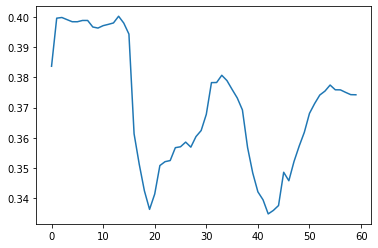

In [8]:
plt.plot(country_arousal[0])

Text(0.5, 1.0, 'off_trend')

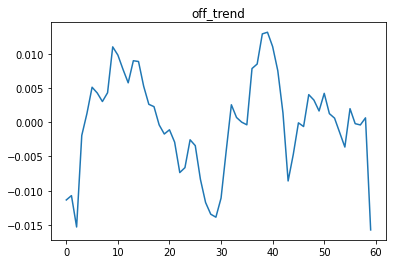

In [9]:
plt.plot(offtrend_country[82])
plt.title('off_trend')

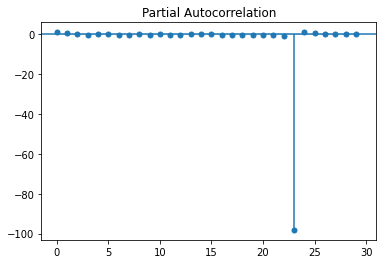

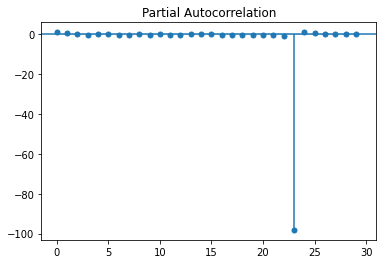

In [10]:
'''
设置是否有周期性的判断阈值为pacf_rate>0.15的原因
'''
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(offtrend_country[82],lags=29)#pacf_rate=0.165344426，认为存在周期性

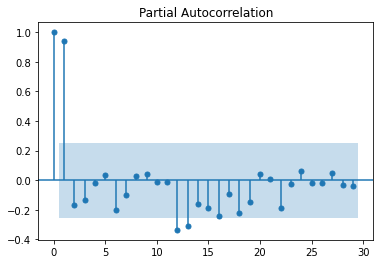

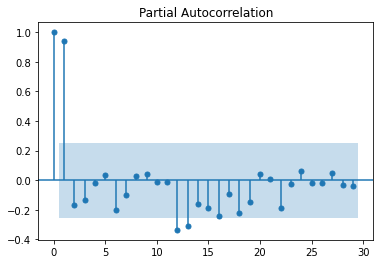

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(offtrend_blues[5],lags=29)#pacf_rate=0.142021255，认为不存在周期性

In [12]:
peroid_total=ifperoid_blues+ifperoid_classical+ifperoid_country+ifperoid_electronic+ifperoid_folk+ifperoid_jazz+ifperoid_pop+ifperoid_rock
sum(peroid_total)#最终744首里有433首有周期性，311首没有周期性

670

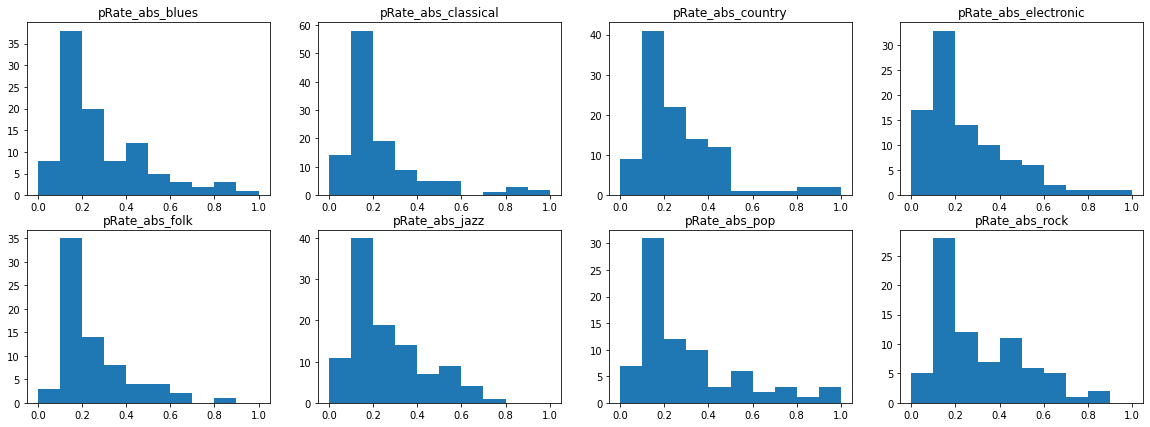

In [13]:
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(20,7))
i=0
j=0
names=['blues','classical','country','electronic','folk','jazz','pop','rock']
for name in names:
    data='pRate_abs_'+name
    the_data=locals()[data]
    the_data=np.round(the_data,4)
    #the_data=abs(the_data)
    ax[i][j].set_title(data)
    ax[i][j].hist(the_data,range=(0,1))
    j=j+1
    if j==4:
        i=1
        j=0

In [14]:
#有周期性的序列中，周期大小的分布
names=['blues','classical','country','electronic','folk','jazz','pop','rock']
for name in names:
    p='ifperoid_'+name
    if_peroid=locals()[p]
    
    p='peroid_'+name
    peroid_index=locals()[p]
    data='pRate_abs_'+name
    pRate=locals()[data]
    peroid_index1=[]
    for i in range(0,len(peroid_index)): 
        if if_peroid[i] == 1:
            peroid_index1.append(pRate[i])
    m=np.mean(peroid_index1)
    print(np.round(m,3))

0.298
0.256
0.281
0.288
0.254
0.285
0.318
0.314


Text(0.5, 1.0, 'resid')

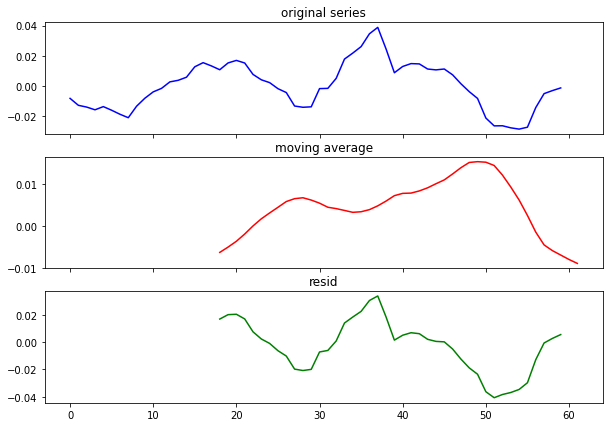

In [17]:
'''
随机误差项分析
'''
#计算移动平均值，再用原始序列减去移动平均值来消除周期
import math
df = pd.Series(offtrend_blues[8])
#print(df)
moving_average = df.rolling(17).mean()
moving_average=moving_average.dropna()
moving_average.index= range(18,len(moving_average) + 18) 
#print(moving_average)
#moving_average=moving_average.fillna(0)
resid=(df-moving_average)#.dropna()
#print(resid)
fig, axarr = plt.subplots(3, sharex=True)
fig.set_size_inches(10, 7)
df.plot(ax=axarr[0], color='b')
axarr[0].set_title('original series')

moving_average.plot(ax=axarr[1], color='r')
axarr[1].set_title('moving average')

resid.plot(ax=axarr[2], color='g')
axarr[2].set_title('resid')

In [18]:
#通过移动平均来消除周期
from statsmodels.tsa import stattools
from numpy import array
import math
names=['blues','classical','country','electronic','folk','jazz','pop','rock']
time=np.arange(60)
for name in names:
    data='offtrend_'+name
    the_data=locals()[data]
    
    ifperoid='ifperoid_'+name
    if_peroid=locals()[ifperoid]
    
    peroid='peroid_'+name
    peroid_values=locals()[peroid]
    off_peroid=[]
    for i in range(0,len(the_data)): 
        if if_peroid[i] == 1:
            df = pd.Series(the_data[i])
            moving_average = df.rolling(peroid_values[i]).mean()
            moving_average=moving_average.dropna()
            index0=math.ceil(peroid_values[i]/2)
            moving_average.index= range(index0,len(moving_average) + index0) 
            resid=(df-moving_average).dropna()
            off_peroid.append(np.array(resid))
        else:
            off_peroid.append(the_data[i])
    exec("offperoid_%s=%s"%(name,off_peroid))#保存变量offperoid_类名

In [19]:
#得到随机误差项后进行ADF检验，验证其平稳性，pvalue越接近于0越平稳，随机性也越好
for name in names:
    data='offperoid_'+name
    the_data=locals()[data]
    pvalue=[]
    index=np.arange(len(the_data))
    for i in range(0,len(the_data)):
        adf_result = stattools.adfuller(the_data[i], autolag='AIC')
        pvalue.append(adf_result[1])
    exec("pvalue_%s=%s"%(name,pvalue))#保存变量pvalue_类名
#     if name=='blues':
#         save_file=pd.DataFrame({'index':index,'pvalue':pvalue})
#         save_file.to_csv('result.csv',index=False)
#     else:
#         save_file=pd.DataFrame({'index':index,'pvalue':pvalue})
#         save_file.to_csv('result.csv',index=False,mode='a')#以追加行的方式写入  sep=','以追加列的方式写入

Text(0.5, 1.0, 'offtrend_classical')

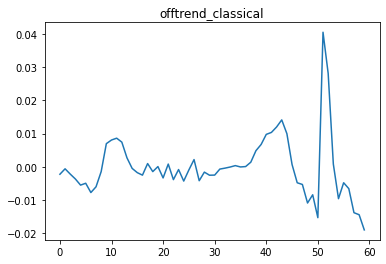

In [20]:
plt.plot(offtrend_classical[3])# Pvalue=0.638621306
plt.title('offtrend_classical')#0.085770745

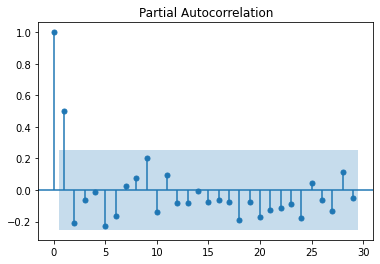

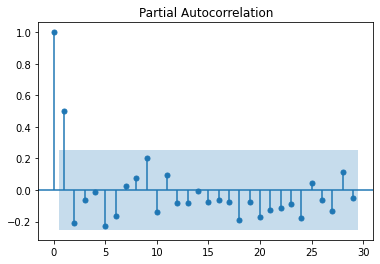

In [21]:
plot_pacf(offtrend_classical[3],lags=29)#pacf_rate=0.148203702，认为不存在周期性

In [25]:
'''
随机分量的熵值计算
'''
from scipy import stats
def Entropy(series, base=2):
    # 计算概率分布
    probs = pd.Series(series).value_counts() / len(series)
    # 计算底数为base的熵
    en = stats.entropy(probs, base=base)#计算公式为-sum(pk * log(pk))
    return en
for name in names:
    data='offperoid_'+name
    the_data=locals()[data]
    entropy=[]
    index=np.arange(len(the_data))
    for i in range(0,len(the_data)):
        ent=Entropy(np.round(the_data[i],4))
        entropy.append(ent)
    exec("entropy_%s=%s"%(name,entropy))

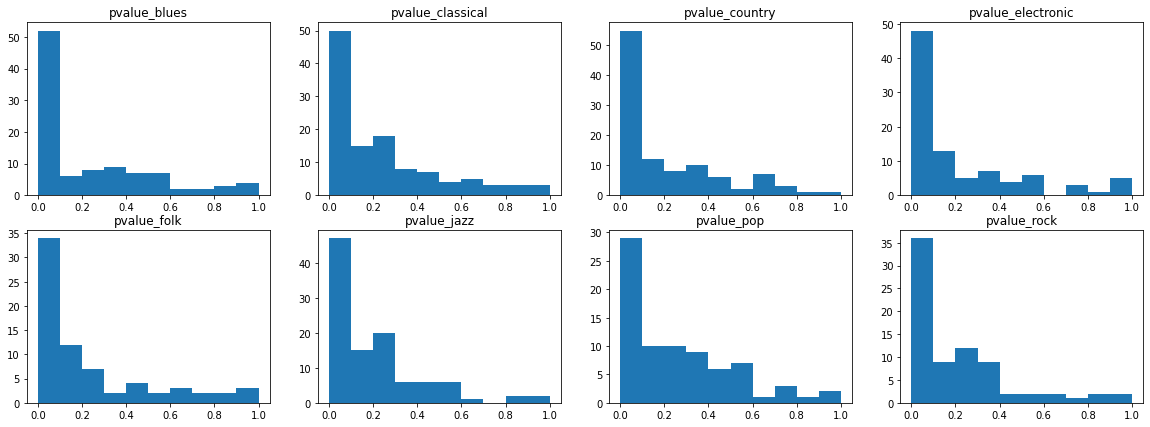

In [26]:
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(20,7))
i=0
j=0
names=['blues','classical','country','electronic','folk','jazz','pop','rock']
for name in names:
    data='pvalue_'+name
    the_data=locals()[data]
    the_data=np.round(the_data,4)
    #the_data=abs(the_data)
    ax[i][j].set_title(data)
    ax[i][j].hist(the_data,range=(0,1))
    j=j+1
    if j==4:
        i=1
        j=0

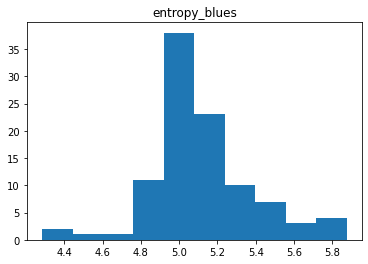

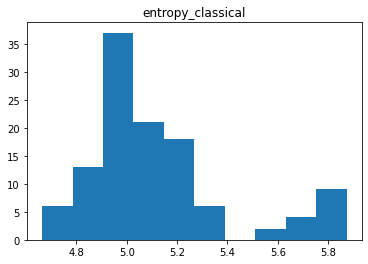

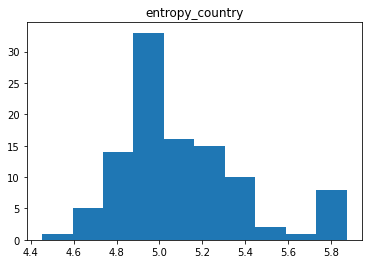

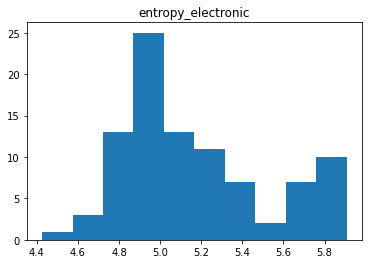

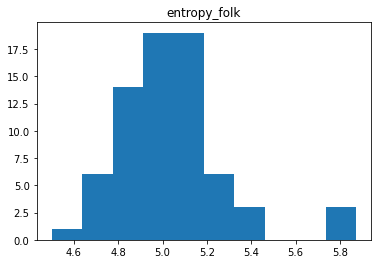

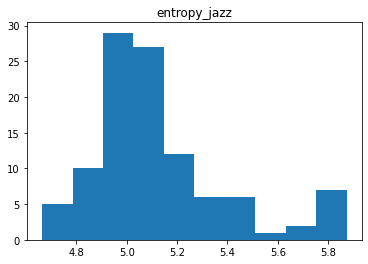

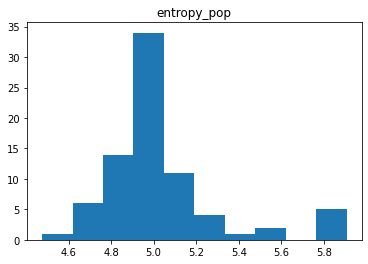

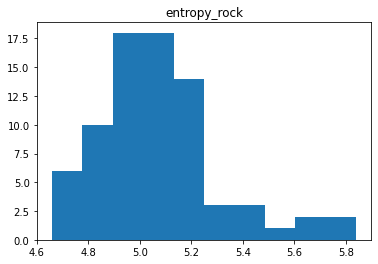

In [27]:
names=['blues','classical','country','electronic','folk','jazz','pop','rock']
for name in names:
    p='entropy_'+name
    entropy=locals()[p]
    plt.figure()
    plt.hist(entropy,bins=10)
    plt.title(p)

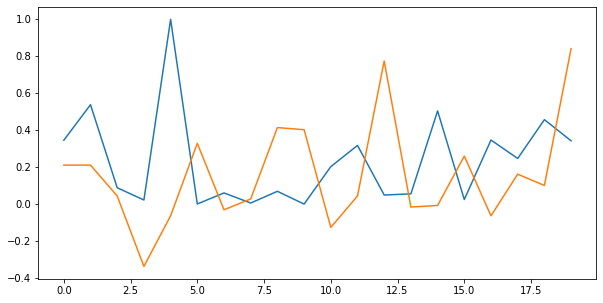

In [28]:
#pvalue和entropy的对比，只拿前20个看看
plt.figure(figsize=(10,5))
plt.plot(pvalue_blues[:20])
a=np.array(entropy_blues)-5
plt.plot(a[:20])#pvalue和entropy走势大体上相反，并且相反的幅度不同。但有的点变化是一致的？

In [29]:
'''
完整代码
'''
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa import stattools
from numpy import array
from scipy import stats
import math
def Linear_trend(series):
    trend_model = LinearRegression(normalize=True,fit_intercept=True)
    time=np.arange(60)
    coefficient_list=[]
    R2_list=[]
    trend_list=[]
    off_trend=[]
    for i in range(0,len(series)):  
        trend_model.fit(np.array(time).reshape(-1, 1),np.array(series[i]).reshape(-1, 1))
        data_pred = trend_model.predict(np.array(time).reshape(-1, 1))
        r2 = r2_score(series[i],data_pred)
        R2_list.append(r2)
        coefficient_list.append(trend_model.coef_[0])
        #先去线性趋势        
        data_pred = np.squeeze(data_pred)#缩减维度
        off_trend.append(series[i]-data_pred) 
    coefficient=np.squeeze(coefficient_list)
    R2=np.squeeze(R2_list)
    return coefficient,R2,off_trend 

def peroid_analysis(series):
    max_list=[]#偏自相关最大值
    index_list=[]#最大值的索引
    rate_rel_list=[]#相对周期显著性
    rate_abs_list=[]#绝对周期显著性
    peroid_list=[]#是否有周期性的01判断  
    trend_model = LinearRegression(normalize=True,fit_intercept=True)
    time=np.arange(60)
    for i in range(0,len(series)): 
        #进行周期性分析
        Pacf=pacf(series[i],nlags=29)[4:]#认为情感感知的变化至少为2s以上，所以从lag=4开始
        pacf_abs=abs(Pacf)
        pacf_max=max(pacf_abs)
        #计算第二大周期值
        a=list(pacf_abs)
        a.remove(pacf_max)
        pacf_sec_max=max(a)
        #周期大小
        index_max=np.argmax(pacf_abs)+4
        pacf_sum=sum(pacf_abs)
        pacf_abs_rate=pacf_max/pacf_sum
        pacf_rel_rate=pacf_max/pacf_sec_max
        if pacf_abs_rate>0.1:
            peroid=1
        else:
            peroid=0
        peroid_list.append(peroid)
        max_list.append(pacf_max)
        index_list.append(index_max)
        rate_abs_list.append(pacf_abs_rate)
        rate_rel_list.append(pacf_rel_rate)
  
    Max=np.squeeze(max_list)
    Index=np.squeeze(index_list)
    Rate_abs=np.squeeze(rate_abs_list)
    Rate_rel=np.squeeze(rate_rel_list)
    if_peroid=np.squeeze(peroid_list)        
    return Max,Index,Rate_abs, Rate_rel,if_peroid


def Entropy(series, base=2):
    # 计算概率分布
    probs = pd.Series(series).value_counts() / len(series)
    # 计算底数为base的熵
    en = stats.entropy(probs, base=base)#计算公式为-sum(pk * log(pk))
    return en
def resid_analysis(off_trend,if_peroid,Index):
    time=np.arange(60)
    for name in names:
        off_peroid=[]
        pvalue=[]
        entropy=[]
        for i in range(0,len(off_trend)): 
            if if_peroid[i] == 1:
                df = pd.Series(off_trend[i])
                moving_average = df.rolling(Index[i]).mean()
                moving_average=moving_average.dropna()
                index0=math.ceil(Index[i]/2)
                moving_average.index= range(index0,len(moving_average) + index0) 
                resid=(df-moving_average).dropna()
                off_peroid.append(np.array(resid))
            else:
                off_peroid.append(off_trend[i]) 
            #得到pvalue和entropy
            adf_result = stattools.adfuller(off_peroid[i], autolag='AIC')
            pvalue.append(adf_result[1])
            ent=Entropy(np.round(off_peroid[i],4))
            entropy.append(ent) 
    return pvalue,entropy


#读取arousal数据
arousal = pd.read_csv('arousal.csv',index_col=0)
data_arousal=[]
for i in range(0,744):
    X=np.array(arousal.iloc[i].dropna(axis=0,how='any'))
    data_arousal.append(X)

#读取valence数据
valence = pd.read_csv('valence.csv',index_col=0)
data_valence=[]
for i in range(0,744):
    X=np.array(valence.iloc[i].dropna(axis=0,how='any'))
    data_valence.append(X)
'''
Blues:0-99(100)   Classical:100-215(116)  Country:216-320(105)  Electronic:321-412(92)
Folk:413-483(71)  Jazz:484-588(105)  Pop:589-666(78)  Rock:667-743(77)
'''
blues_arousal,blues_valence=data_arousal[0:100],data_valence[0:100]
classical_arousal,classical_valence=data_arousal[100:216],data_valence[100:216]
country_arousal,country_valence=data_arousal[216:321],data_valence[216:321]
electronic_arousal,electronic_valence=data_arousal[321:413],data_valence[321:413]
folk_arousal,folk_valence=data_arousal[413:484],data_valence[413:484]
jazz_arousal,jazz_valence=data_arousal[484:589],data_valence[484:589]
pop_arousal,pop_valence=data_arousal[589:667],data_valence[589:667]
rock_arousal,rock_valence=data_arousal[667:744],data_valence[667:744]
names=['blues','classical','country','electronic','folk','jazz','pop','rock']
for name in names:
    data=name+'_arousal'#改为valence
    the_data=locals()[data]
    coefficient,R2,off_trend=Linear_trend(the_data)
    Max,Index,Rate_abs,Rate_rel,if_peroid=peroid_analysis(off_trend)
    pvalue,entropy=resid_analysis(off_trend,if_peroid,Index)
  
    index=np.arange(len(the_data))
    genre=[]
    for i in range(0,len(the_data)):
        genre.append(name)
    if name=='blues':
        save_file=pd.DataFrame({'index':index,'genre':genre,'coefficient':coefficient,'R2':R2,
                                'pacf_max':Max,'pacf_index':Index,'pacf_abs_rate':Rate_abs,'pacf_rel_rate':Rate_rel,'if_peroid':if_peroid,
                                'pvalue':pvalue,'entropy':entropy})
        save_file.to_csv('sample_feature_arousal.csv',index=False)
    else:
        save_file=pd.DataFrame({'index':index,'genre':genre,'coefficient':coefficient,'R2':R2,
                                'pacf_max':Max,'pacf_index':Index,'pacf_abs_rate':Rate_abs,'pacf_rel_rate':Rate_rel,'if_peroid':if_peroid,
                                'pvalue':pvalue,'entropy':entropy})
        save_file.to_csv('sample_feature_arousal.csv',header=False,index=False,mode='a')

In [ ]:
names=['blues','classical','country','electronic','folk','jazz','pop','rock']
coef_mean=[]
R2_mean=[]
pRate_abs_mean=[]
pRate_abs_mode=[]
pRate_rel_mean=[]
pRate_rel_mode=[]
index_mean=[]
index_mode=[]
pvalue_mean=[]
entropy_mean=[]
for name in names:
    data=name+'_arousal'#改为valence
    the_data=locals()[data]
    coefficient,R2,off_trend=Linear_trend(the_data)
    Max,Index,Rate_abs,Rate_rel,if_peroid=peroid_analysis(off_trend)
    pvalue,entropy=resid_analysis(off_trend,if_peroid,Index)
    
    coef_mean.append(np.mean(coefficient))#线性趋势斜率均值
    R2_mean.append(np.mean(R2))#R2均值
    pRate_abs_mean.append(np.mean(Rate_abs))#周期绝对显著性均值
    pRate_abs_mode.append(stats.mode(Rate_abs)[0][0])#周期绝对显著性众数
    pRate_rel_mean.append(np.mean(Rate_rel))#周期相对显著性均值
    pRate_rel_mode.append(stats.mode(Rate_rel)[0][0])#周期相对显著性众数
    index_mean.append(np.mean(Index))#周期大小均值
    index_mode.append(stats.mode(Index)[0][0])#周期大小均值
    pvalue_mean.append(np.mean(pvalue))#pvalues均值
    entropy_mean.append(np.mean(entropy))#熵值均值

save_file=pd.DataFrame({'genre':names,'coef_mean': coef_mean,'R2_mean':R2_mean,
                        'pRate_abs_mean':pRate_abs_mean,'pRate_abs_mode':pRate_abs_mode,'pRate_rel_mean':pRate_rel_mean,'pRate_rel_mode':pRate_rel_mode,'index_mean':index_mean,'index_mode':index_mode,
                        'pvalue_mean':pvalue_mean,'entropy_mean':entropy_mean})
save_file.to_csv('genre_feature_arousal.csv',index=False)#以追加列的方式写入